In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.31.0
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


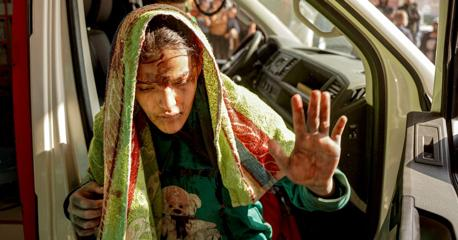

[Maybe AI can give humans an excuse to be less ethical.](https://www.vox.com/future-perfect/24151437/ai-israel-gaza-war-hamas-artificial-intelligence) - Vox

___

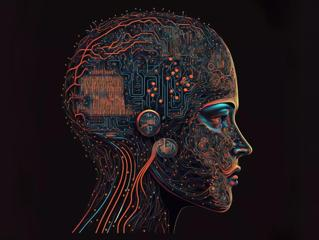

[AI found to be a decent ethicist. 

Ethics is maybe just strategic thinking with a long time frame and objective function inclusive of others besides oneself? Do unto others etc.](https://www.businessinsider.in/tech/ai/news/people-find-chatgpt-to-have-a-better-moral-compass-than-real-humans-study-reveals/articleshow/109953225.cms) - Business Insider

___

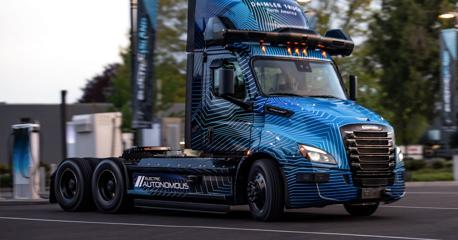

[Daimler driverless trucks to hit the road in 2027.](https://www.theverge.com/2024/5/8/24151391/daimler-truck-autonomous-demonstrator-torc-waymo) - The Verge

___

[Pichai talks to Emily Chang and lays out his AI roadmap.](https://www.bloomberg.com/news/articles/2024-05-08/video-alphabet-ceo-sundar-pichai-lays-out-google-s-ai-roadmap)

___

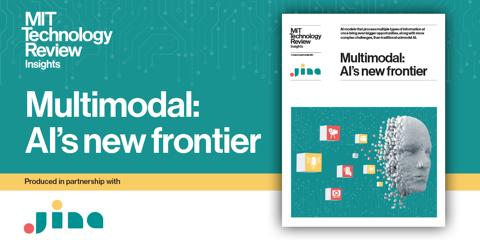

[Multimodal is AI's new frontier.](https://www.technologyreview.com/2024/05/08/1092009/multimodal-ais-new-frontier/) - MIT Technology Review

___

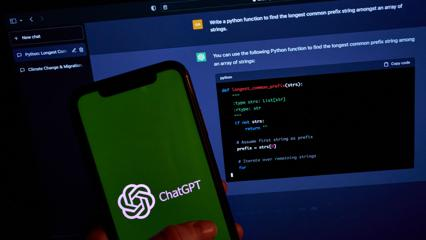

[Record on-the-job AI use, but employees keep it secret because they don't want to seem replaceable.](https://www.cnbc.com/2024/05/08/workers-hiding-ai-use-on-important-tasks-over-fears-about-being-replaced-report-.html) - CNBC

___

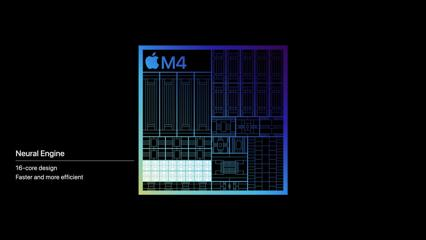

[M4 seems an incremental improvement over M3 with AI optimizations. I always see these demos and get super pumped to buy it and then an hour later ask myself why exactly?](https://www.tomshardware.com/pc-components/cpus/alleged-apple-m4-geekbench-scores-show-incremental-improvement-in-machine-learning-over-last-gen) - Tom's Hardware

___

[US considers export controls on ChatGPT and LLMs.](https://www.reuters.com/technology/us-eyes-curbs-chinas-access-ai-software-behind-apps-like-chatgpt-2024-05-08/)

___

It's a weird time when the richest people in the world, the people who benefit the most, like Elon Musk, think they will benefit by destroying trust in the system and 'disrupting' everything. Usually the people like that are the mountebanks and fraudulent con men? 🤔 Be careful what you wish for.

[Stuff like AI, Bitcoin, conspiracy theories destroy trust. Society runs on trust, so it's a dangerous game. We are in a crisis of institutional legitimacy and democracy, and when people lose trust you have massive financial crises, wacko strongmen etc.](https://cointelegraph.com/news/ai-finance-yuval-noah-harari-bis)

___

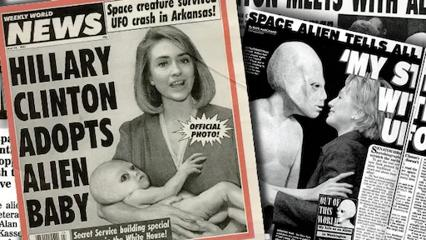

[I wrote about this. The average person is not that smart, but they are also not that dumb. The bullshit economy demands bullshit. Bullshit is the homage that ignorance pays to knowledge, or something.](https://medium.com/@druce/on-bullshit-fad43052b978) - Medium

___

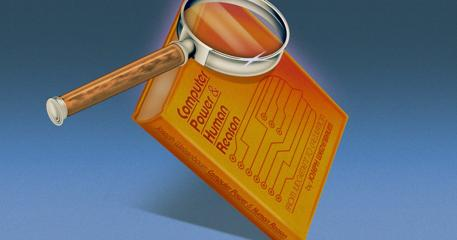

[Weizenbaum warned us about AI. 

People demand to be bamboozled by bullshit.](https://newrepublic.com/article/181189/inventor-chatbot-tried-warn-us-ai-joseph-weizenbaum-computer-power-human-reason) - The New Republic

___

[John Wick pinball machine touts an adversarial AI features.](https://www.ign.com/articles/john-wick-pinball-machine-announced-touts-pinballs-first-ai-augmented-software)

___

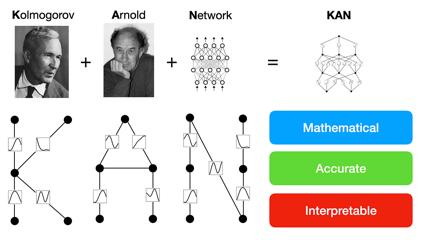

[Understanding KAN networks, an alternative to MLPs, the basic deep learning architecture.](https://towardsdatascience.com/kolmogorov-arnold-networks-kan-e317b1b4d075) - Medium

___

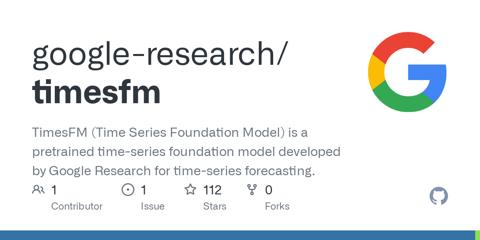

[Google releases a TimesFM time series foundation model.](https://github.com/google-research/timesfm?tab=readme-ov-file) - GitHub

___

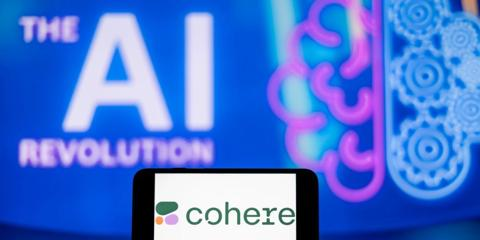

[Is there such thing as a 'major pre-seed round'? If \\$10m is 'pre-seed' then what is the new seed round?](https://www.businessinsider.com/london-ai-startup-convergence-raising-pre-seed-024-5) - Business Insider

___

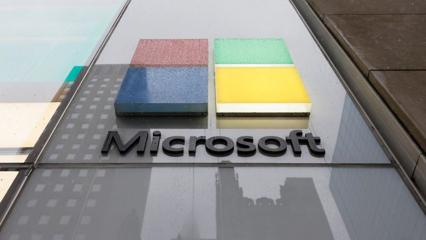

[Biden to travel to Wisconsin to announce Microsoft AI hub on the land where Trump promised a huge Foxconn facility 6 years ago. So much winning.](https://www.cnn.com/2024/05/08/tech/microsoft-ai-wisconsin/index.html) - CNN

___

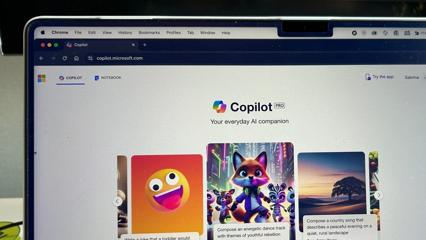

[Microsoft Copilot adds prompt engineering features, including 'rewrite'.](https://www.zdnet.com/article/these-four-new-copilot-for-microsoft-365-features-make-prompt-writing-like-a-pro-even-easier/) - ZDNET

___

[Oracle releases code assistant for Java and SQL.](https://venturebeat.com/ai/oracle-code-assist-revealed-ai-powered-coding-assistant/)

___

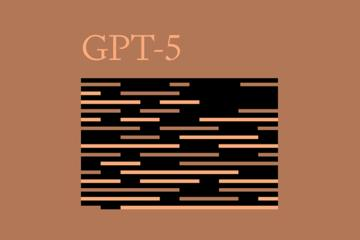

[A roundup of news and rumor about GPT-5 and other models lifearchitect.ai/gpt-5/](https://lifearchitect.ai/gpt-5/) - Dr Alan D. Thompson – Life Architect

___

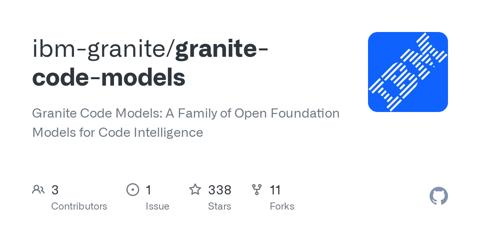

[IBM releases open source code assistant model, small ones you could run locally are pretty good, probably not competitive with e.g. GitHub Copilot.](https://github.com/ibm-granite/granite-code-models) - GitHub

___

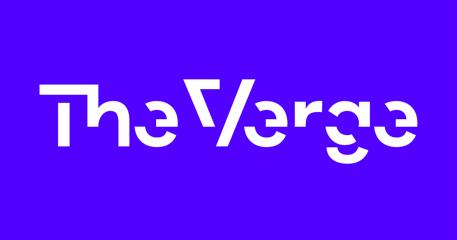

[Sources tell the Verge that OpenAI is aggressively poaching Googlers for their search effort.](https://www.theverge.com/2024/5/7/24151616/openai-is-entering-the-search-game) - The Verge

___

[Bloomberg writes about OpenAI's search effort, which might ship with tomorrow's announcement.](https://www.bloomberg.com/news/articles/2024-05-07/openai-is-readying-an-ai-search-product-to-rival-google-perplexity)

___

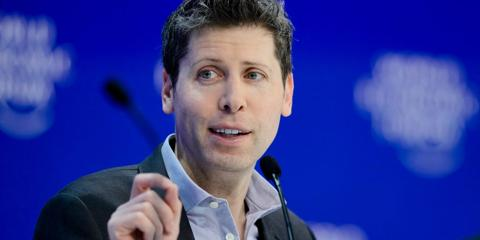

[Lawsuit asked for 2 older books datasets used to train GPT-3, OpenAI said they deleted the datasets and the employees who compiled them are gone. 🤔](https://www.businessinsider.com/openai-destroyed-ai-training-datasets-lawsuit-authors-books-copyright-2024-5) - Business Insider

___

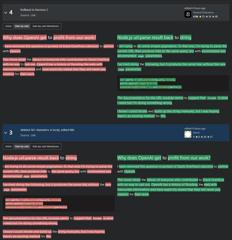

[Some StackOverflow users are unhappy about the vague OpenAI deal, are deleting answers, getting suspended.](https://m.benui.ca/@ben/112396505994216742) - benui mastodon instance

___

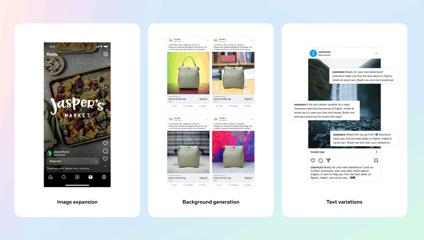

[Meta let's advertisers use gen AI tools to create new advertising images.](https://techcrunch.com/2024/05/07/metas-ai-tools-for-advertisers-can-now-create-new-images-not-just-new-backgrounds/) - TechCrunch

___

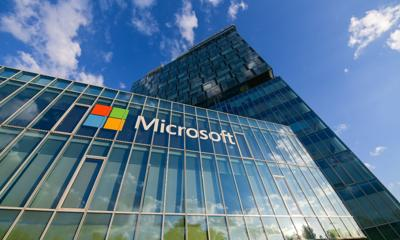

[Microsoft ships air-gapped OpenAI models for US spy agencies.](https://www.pymnts.com/artificial-intelligence-2/2024/report-microsoft-develops-internet-free-ai-model-for-spy-agencies/) - PYMNTS.com

___

[Microsoft pauses Windows Copilot rollout based on user feedback about bugs and annoyances.](https://www.theregister.com/2024/05/07/microsoft_copilot_windows_insiders/)

___

[Apple releases M4, claims hefty NPU TOPS…on an iPad.](https://www.theregister.com/2024/05/07/apple_m4_ipad/)

___

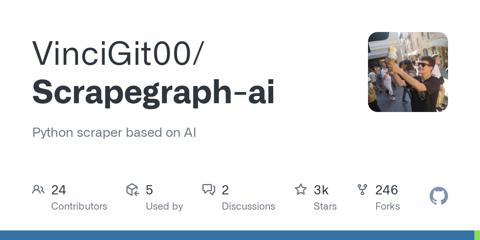

[An LLM-enabled web scraping library](https://github.com/VinciGit00/Scrapegraph-ai) - GitHub

___

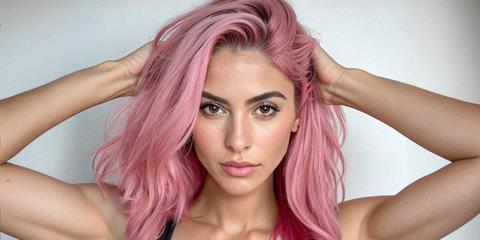

[How AI is changing OnlyFans](https://www.businessinsider.com/how-onlyfans-adult-creators-are-embracing-ai-chatbot-twins-images-2024-5) - Business Insider

___

'gpt2' is back in Chatbot Arena in 2 flavors.

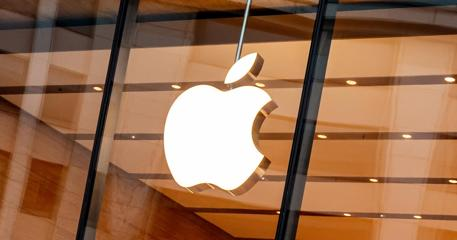

[Safari 18 rumored to have an AI 'summarize' this page feature, let you block elements.](https://www.searchenginejournal.com/apples-intelligent-search-will-summarize-webpages/515564/) - Search Engine Journal

___

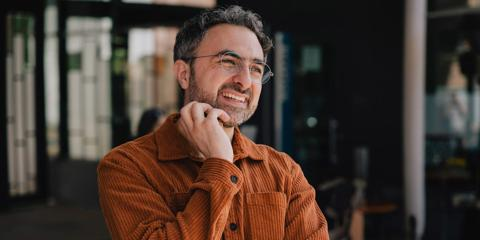

[Mustafa Suleyman looks back on his first month at Microsoft.](https://www.businessinsider.com/mustafa-suleyman-microsoft-ai-first-business-2024-5) - Business Insider

___

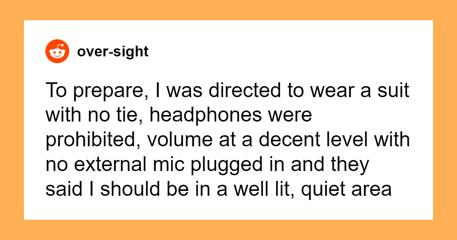

[Getting interviewed by AI is the latest job search humiliation.](https://www.boredpanda.com/job-interview-with-ai-antiwork/) - Bored Panda

___

[WSJ on Apple chips. Sounds maybe like Groq inference chips. 

I guess this will be a category, the workload is different from training, apps like Amazon will spend to keep consumer attention by giving answers faster and reduce latency even at the cost of specialized chips with lots of fast memory.](https://www.wsj.com/tech/ai/apple-is-developing-ai-chips-for-data-centers-seeking-edge-in-arms-race-0bedd2b2)

___

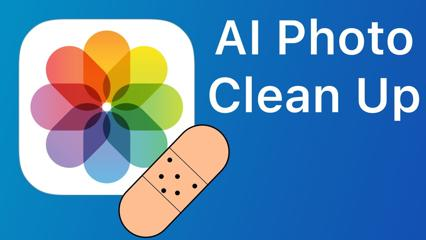

[Apple teases gen-AI for image editing.](https://appleinsider.com/articles/24/05/06/apples-new-photos-app-will-utilize-generative-ai-for-image-editing) - AppleInsider

___

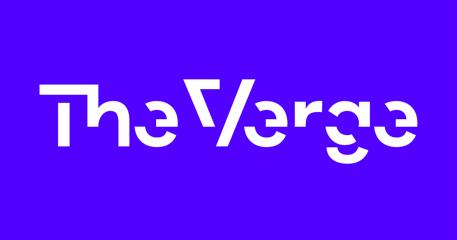

[WSJ says Apple is making AI chips for data centers. Bloomberg begs to differ.](https://www.theverge.com/2024/5/6/24150742/apples-project-acdc-is-building-ai-chips-for-data-centers) - The Verge

___

[Also in 'AI gone wild', Grok can now summarize events that haven't taken place yet.](https://twitter.com/MKBHD/status/1787553324243259718)

___

[Google suggests drinking 2 liters of urine to help pass kidney stones.](https://technology.inquirer.net/134286/google-search-ai)

___

[ChatGPT is now at chatgpt.com, possibly in preparation to releasing e.g. search.chatgpt.com on Thursday.](https://chatgpt.com)

___

[OpenAI releases a model they say can detect Dall-E AI photos 98% of the time.](https://www.nytimes.com/2024/05/07/technology/openai-deepfake-detector.html)

___

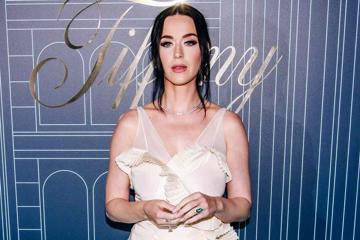

[Katy Perry shares an image of herself at the Met gala, but she wasn't there and it was AI.](https://people.com/katy-perry-met-gala-ai-image-fooled-her-mom-8637071) - Peoplemag

___

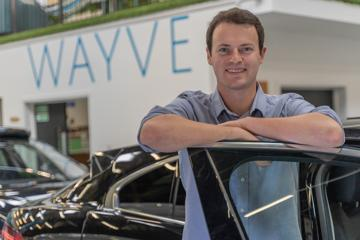

[Wayve raises over \\$1b from Softbank for self-driving technology.](https://techcrunch.com/2024/05/06/wayve-raises-1-billion-led-by-softbank-to-take-self-driving-to-cars-and-robots/) - TechCrunch

___

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


[BCG report on AI transformation of asset management](https://web-assets.bcg.com/a3/8a/9a5b5365468d8e5db5993160fa2a/2024-gam-report-may-2024-r.pdf)

___

coming soon to ChatGPT, answers straight from the bowels of hell.

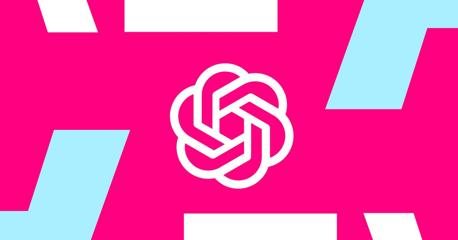

[OpenAI and Stack Overflow partner on AI question answering for nerds.](https://www.theverge.com/2024/5/6/24150341/openai-stack-overflow-partner-api-coding-assistance) - The Verge

___

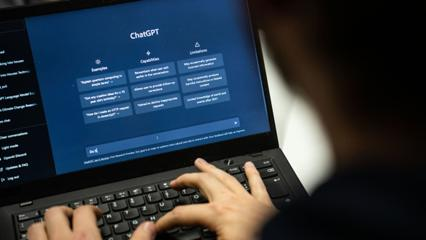

[Gen Z working smart, not hard.](https://www.cnbc.com/2024/05/06/career-consultant-says-gen-z-are-misusing-ai-to-generate-cover-letters.html) - CNBC

___

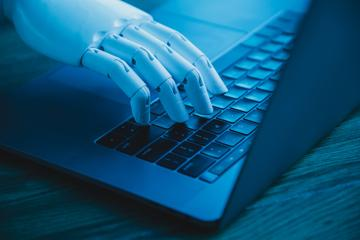

[An app called Vera AI offers to make an avatar of your dead family members.](https://bgr.com/tech/this-ai-app-clones-your-dead-family-members-and-people-are-horrified/) - BGR

___

[Microsoft hedges OpenAI bet, builds its own GPT.](https://www.theinformation.com/articles/meet-mai-1-microsoft-readies-new-ai-model-to-compete-with-google-openai)

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [10]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 5, 8, 15, 47, 49, 99000)

In [12]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-05-07 05:49:33.300280
